In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "8"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# plt.style.use('dark_background')
import h5py
import skopt
import scipy as sc
from skopt.space import Real
from skopt.learning import GaussianProcessRegressor as GPR
from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel, Product, ConstantKernel
%run ./Functions_Test.ipynb
%run ./Val_Functions.ipynb
import matplotlib as mpl
import time
import math
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

### Dataset generation

(1438, 4000, 9) (5752000, 9)
[0.00463421 0.00274448 0.00154149 0.0014369  0.00280263 0.00324911
 0.00284277 0.00143675 0.00143555]


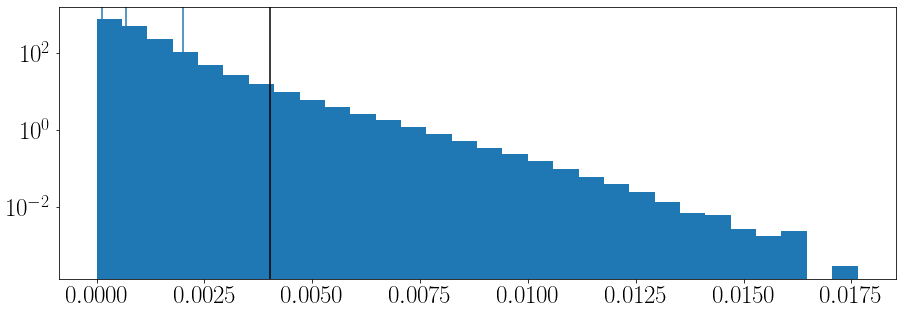

0.05985675025751997 0.0631508261395143
33 1
115.18181818181819


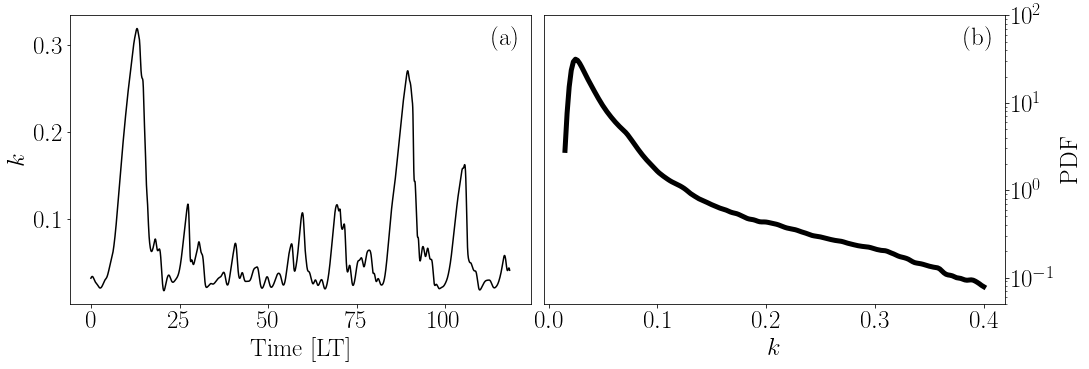

In [4]:
Ndim      = 9
idx       = range(Ndim)
idx1      = idx

hf       = h5py.File('./data/MFE_Sri_RK4_dt=0.25kt=048.h5','r')
UU       = np.array(hf.get('q'))[:,::4,idx]
hf.close()


N1_val = 10

N0 = UU.shape[0]
N1 = UU.shape[1]
U = UU.reshape(N0*N1, Ndim)
print(UU.shape, U.shape)

# Set a target SNR in decibel
target_snr_db = 30
sig_avg_watts = np.var(U,axis=0) #signal power
sig_avg_db = 10 * np.log10(sig_avg_watts) #convert in decibel
# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
print(np.sqrt(noise_avg_watts))
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.zeros(U.shape)
seed = 0                        #to be able to recreate the data
rnd  = np.random.RandomState(seed)
for i in range(Ndim):
    noise_volts[:,i] = rnd.normal(mean_noise, np.sqrt(noise_avg_watts[i]),
                                       U.shape[0])

UUU  = U + noise_volts

# UUU  = UUU.reshape(N0,N1,Ndim)


kinetic   = 0.5*np.linalg.norm(U,axis=1)**2
kin_noise = 0.5*np.linalg.norm(UUU,axis=1)**2

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25
mean_k    = np.mean(kinetic)
plt.yscale('log')
threshold = (.1-mean_k)/10
plt.hist(np.abs(kinetic-kin_noise),density=True,bins=30)
q1 = .1 ; q2 = 1-q1
plt.axvline(threshold,c='k')
plt.axvline(np.median(np.abs(kinetic-kin_noise)))
plt.axvline(np.quantile(np.abs(kinetic-kin_noise),q1))
plt.axvline(np.quantile(np.abs(kinetic-kin_noise),q2))
plt.show()

print(np.mean(kinetic), np.std(kinetic))

t_lyap    = 0.0296**(-1)    # Lyapunov time
dt        = 1      # timestep 
N_lyap    = int(t_lyap/dt)  # number of time steps in one Lyapunov time
print(N_lyap, dt)

# number of time steps for washout, train, validation, test
N_washout = 100 #1*N_lyap
N_train   = N1 - 3*N_lyap - N_washout # 196*N_lyap
N_val     = 3*N_lyap
N_test    = 500*N_lyap

print(N_train/N_lyap)

#compute norm
U_data = U[:N_washout+N_train+N_val]
m = U_data.min(axis=0)
M = U_data.max(axis=0)
norm = M-m

UUU  = UUU.reshape(N0,N1,Ndim)

# washout
U_washout = UU[:N1_val,:N_washout]
# training
U_t   = UU[:N1_val,N_washout:N_washout+N_train-1]
Y_t   = UU[:N1_val,N_washout+1:N_washout+N_train]
# training + validation
U_tv  = UU[:N1_val,N_washout:N_washout+N_train+N_val-1]
Y_tv  = UU[:N1_val,N_washout+1:N_washout+N_train+N_val]
NN    = N1_val
k_tv  = 0.5*np.linalg.norm(UUU[:NN].reshape(NN*N1, Ndim), axis=1)**2
# validation
Y_v  = UU[:N1_val,N_washout+N_train:N_washout+N_train+N_val]

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25
ax, fig = plt.subplots(1,2)

plt.subplot(121)
plt.plot(np.arange(N_train+N_val-1)/N_lyap,
                  0.5*np.linalg.norm(U_tv[0,:,idx].T,axis=1)**2, c='k')
plt.annotate('(a)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
plt.ylabel('$k$')
plt.xlabel('Time [LT]')

axx = plt.subplot(122)
N_range=(0.015,0.41)
N_rang1=(0.015,N_range[1]-0.01)
plt.ylim(0.05,100)
axx.yaxis.set_label_position("right")
axx.yaxis.tick_right()
Y_stats = kinetic
mask    = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
Y_stats = Y_stats[mask]
density1 = sc.stats.gaussian_kde(Y_stats)
n, y, _ = plt.hist(Y_stats, bins=200, range=N_rang1, # bins=np.linspace(minn,maxx, 100) 
                   histtype=u'step', density=True, log=True, alpha=0.001, color='k')
dy      = density1(y)
plt.plot(y, dy, label='True', linewidth=5, c='black')
plt.xlabel('$k$')
plt.ylabel('PDF')
plt.annotate('(b)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')

ax.tight_layout(pad=0.1)
plt.savefig('k_time_pdf.pdf')

plt.show()

In [3]:
# NN_units = [2000]

# vals     = [SSV]#[SSV, KFC, RVC, RVC_PI]

# plt.rcParams["figure.figsize"] = (12,4*len(NN_units))
# plt.rcParams["font.size"] = 25
# plt.subplots(len(NN_units),1)

# N_range=(0.005,0.48)
# N_rang1=(N_range[0]+0.01,N_range[1]-0.01)

# # Test
# Y_stats  = kinetic#[:100*N1]
# mask     = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
# Y_stats  = Y_stats[mask]
# density1 = sc.stats.gaussian_kde(Y_stats)
# n, y1, _  = plt.hist(Y_stats, bins=200, range=N_rang1, # bins=np.linspace(minn,maxx, 100) 
#                    histtype=u'step', density=True, log=True, alpha=0.001, color='k')
# dy1      = density1(y1)

# Y_stats  = kinetic[:200*N1]
# mask     = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
# Y_stats  = Y_stats[mask]
# density1 = sc.stats.gaussian_kde(Y_stats)
# n, y, _  = plt.hist(Y_stats, bins=200, range=N_rang1, # bins=np.linspace(minn,maxx, 100) 
#                    histtype=u'step', density=True, log=True, alpha=0.001, color='k')
# dy       = density1(y)

# # Train
# Y_stats   = k_tv
# mask      = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
# Y_stats   = Y_stats[mask]
# density0  = sc.stats.gaussian_kde(Y_stats)
# nn, yy, _ = plt.hist(Y_stats, bins=200, range=N_rang1, #np.linspace(minn,maxx, 100), 
#                    histtype=u'step', density=True, log=True, alpha=0.001, color='k')
# dyy       = density0(yy)

# k_u       = 0
# errors    = np.zeros((len(NN_units),len(val)))
# for N_units in NN_units:
    
#     plt.subplot(len(NN_units),1,k_u+1)
#     plt.ylim(0.01,100)
#     plt.plot(y, dy, label='True', linewidth=8, c='black')
#     plt.plot(y1, dy1, label='True1', c='darkgrey')
    
#     k_v   = 0
#     for j in vals:

#         fln = '/data/ar994/Python/Unmeasured_Extreme_Events/Post_Process_data/' \
#                   + j.__name__ + '_Statss_' + str(N_units) + '.h5'
#         hf = h5py.File(fln,'r')
#         Y_stats = np.array(hf.get('Y_stats'))[:]
#         hf.close()

#         print(Y_stats.shape)

#         b  = N_range[0]
#         kk = 0
#         for jj in range(Y_stats.shape[0]):
#             k  = 0
#             k1 = 0
#             a  = 0.5*np.linalg.norm(Y_stats[jj],axis=2)**2
#             for i in range(a.shape[0]):

#                 minn = a[k,-10*N_lyap:-1].min()
#                 maxx = a[k,-10*N_lyap:-1].max()
#                 if (maxx - minn < 0.01 and minn > 0.05) or a[k].max() > 0.48:
#                     a = np.delete(a,k,axis=0)
#                     k  += -1
#                     k1 += 1


#                 k += 1

#             kk += k1

#             b = np.append(b,a.flatten())

#         Y_stats     = b 
#         mask        = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
#         Y_stats     = Y_stats[mask]
#         density2    = sc.stats.gaussian_kde(Y_stats)
#         nnn, yyy, _ = plt.hist(Y_stats, bins=200, range=N_rang1, # bins=np.linspace(minn,maxx, 100) 
#                            histtype=u'step', density=True, log=True, alpha=0.001, color='k')
#         dyyy        = density2(yyy)
#         plt.plot(yyy, dyyy, label='$'+j.__name__+'$', linewidth=3, alpha=0.8)
#         errors[k_u,k_v] = (np.abs(dyyy-dy)/dy).mean()
#         print(j.__name__, kk/(i+1)/(jj+1), (np.abs(dyyy-dy)/dy).mean())
#         k_v         += 1

#     plt.plot(yy, dyy, '--C4', label='Train', linewidth=3, alpha=0.5)
#     err_train = (np.abs(dyy-dy)/dy).mean()
#     print('Train', err_train)
#     plt.annotate(str(N_units) + ' Neurons', xy=(0, 0), xytext=(10, 10), va='bottom', ha='left',
#              xycoords='axes fraction', textcoords='offset points')
    
#     plt.ylim()
#     if k_u == len(NN_units)-1:
#         plt.xlabel('Kinetic Energy')
#     else:
#         plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)
#     plt.ylabel('PDF')
#     k_u += 1
    
# plt.legend(ncol=2)
# plt.tight_layout(pad=0.1)
# plt.savefig('Stats_' + str(N_units) + '.pdf')

# plt.rcParams["figure.figsize"] = (5,5)
# plt.rcParams["font.size"] = 25
# plt.figure()
# plt.yscale('log')
# plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
# plt.axhline(err_train, c='C4', linestyle='--')
# plt.plot(NN_units, errors, '-', marker='o')
# plt.xlabel('Neurons')
# plt.ylabel('Relative Error')

# plt.show()


(0.015, 0.47)
SSV 40 500 0.2584
RVC 40 500 0.2028
SSV 40 1000 0.1582
RVC 40 1000 0.16399999999999998
SSV 40 1500 0.22400000000000003
RVC 40 1500 0.23759999999999998
SSV 40 2000 0.30179999999999996
RVC 40 2000 0.2734
SSV 40 2500 0.3638
RVC 40 2500 0.3186
SSV 40 3000 0.4598
RVC 40 3000 0.42800000000000005


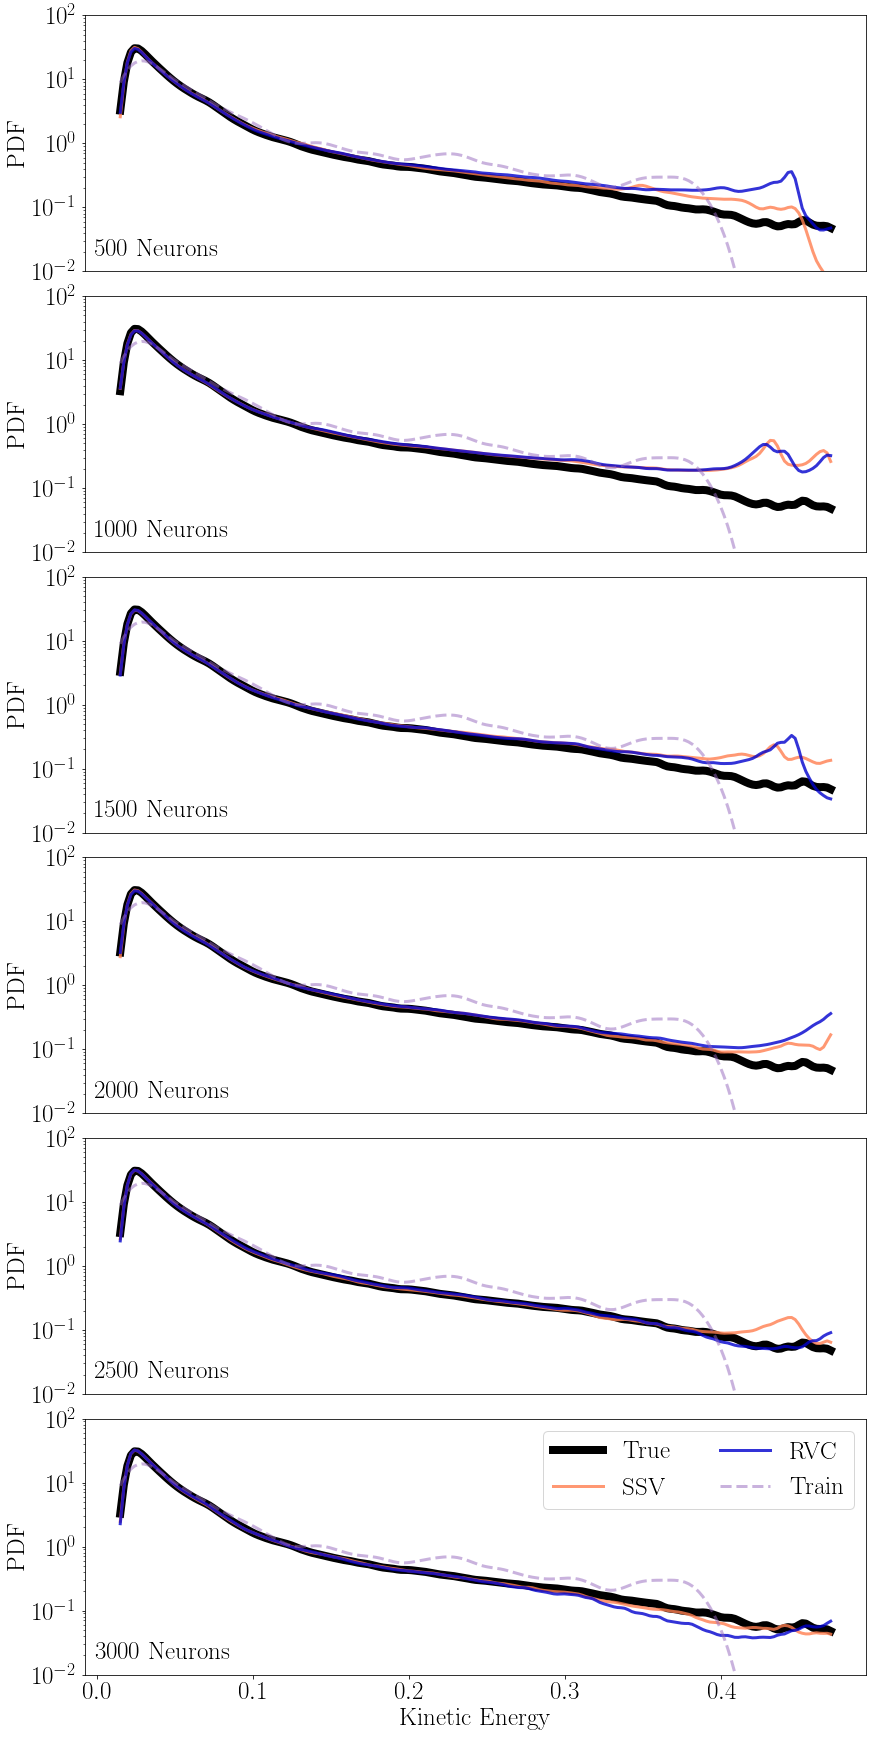

In [92]:
NN_units = [500,1000,1500,2000,2500,3000]
vals     = [SSV,RVC]
SNRs     = [40]
# target_snr_db = SNRs[0]
ensemble = 10

bins      = 200
errors    = np.zeros((ensemble,len(NN_units),len(vals), len(SNRs)))
hists     = np.zeros((ensemble,len(NN_units),len(vals), len(SNRs), bins))

N_range=(0.005,0.48)
N_rang1=(N_range[0]+0.01,N_range[1]-0.01)

print(str(N_rang1))

# Test
Y_stats  = kinetic
mask     = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
Y_stats  = Y_stats[mask]
density1 = sc.stats.gaussian_kde(Y_stats)
n, y     = np.histogram(Y_stats, bins=bins, range=N_rang1,density=True)
dy       = density1(y)

# Short Test
Y_stats   = kinetic[:200*N1]
mask      = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
Y_stats   = Y_stats[mask]
n1        = np.histogram(Y_stats, bins=bins, range=N_rang1,density=True)[0]
err_short = (np.abs(n1-n)/n).mean()

# Train
Y_stats   = k_tv
mask      = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
Y_stats   = Y_stats[mask]
density0  = sc.stats.gaussian_kde(Y_stats)
nn        = np.histogram(Y_stats, bins=bins, range=N_rang1,density=True)[0]
dyy       = density0(y)
err_train = (np.abs(nn-n)/n).mean()

plt.rcParams["figure.figsize"] = (12,4*len(NN_units))
plt.rcParams["font.size"] = 25
plt.subplots(len(NN_units),1)

labels  = [ vals[i].__name__ for i in range(len(vals))]
colors  = ['coral', 'mediumblue', 'teal', 'violet']

k_u       = 0

for N_units in NN_units:
    
    plt.subplot(len(NN_units),1,k_u+1)
    plt.ylim(0.01,100)
    plt.plot(y, dy, label='True', linewidth=8, c='black')
    
    k_t = 0
        
    for target_snr_db in SNRs:
        
        k_v   = 0
        for j in vals:

            fln = '/data/ar994/Python/Unmeasured_Extreme_Events/Post_Process_data/Noise/' \
                      + j.__name__ + '_Statss_' + str(target_snr_db) + '_' + str(N_units) + '.h5'
            hf = h5py.File(fln,'r')
            Y_stats = np.array(hf.get('Y_stats'))[:]
            hf.close()

            b  = 0
            kk = 0
            for jj in range(Y_stats.shape[0]):
                k  = 0
                k1 = 0
                a  = 0.5*np.linalg.norm(Y_stats[jj],axis=2)**2
                for i in range(a.shape[0]):

                    minn = a[k,-10*N_lyap:-1].min()
                    maxx = a[k,-10*N_lyap:-1].max()
                    if (maxx - minn < 0.01 and minn > 0.05) or a[k].max() > 0.48:
                        a = np.delete(a,k,axis=0)
                        k  += -1
                        k1 += 1

                    k += 1

                kk += k1

                if a.shape[0] > 0:
                    Y_statss               = a.flatten() 
                    mask                   = (Y_statss < N_range[1]) & (Y_statss > N_range[0])
                    Y_statss               = Y_statss[mask]
                    hists[jj,k_u,k_v,k_t]  = np.histogram(Y_statss, bins=bins,
                                                      range=N_rang1,density=True)[0]
                    errors[jj,k_u,k_v,k_t] = (np.abs(hists[jj,k_u,k_v,k_t]-n)/n).mean()

                b = np.append(b,a.flatten())

            Y_stats     = b 
            mask        = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
            Y_stats     = Y_stats[mask]
            density2    = sc.stats.gaussian_kde(Y_stats)
            dyyy        = density2(y)
            plt.plot(y, dyyy, label=labels[k_v], c=colors[k_v], linewidth=3, alpha=0.8)

            print(j.__name__, target_snr_db, N_units, kk/(i+1)/(jj+1))
            k_v         += 1

        k_t += 1
    
    plt.plot(y, dyy, '--C4', label='Train', linewidth=3, alpha=0.5)
    
    plt.annotate(str(N_units) + ' Neurons', xy=(0, 0), xytext=(10, 10), va='bottom', ha='left',
             xycoords='axes fraction', textcoords='offset points')
    
    plt.yscale('log')
    plt.ylim()
    if k_u == len(NN_units)-1:
        plt.xlabel('Kinetic Energy')
    else:
        plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)
    plt.ylabel('PDF')
    k_u += 1
    
plt.legend(ncol=2)
plt.tight_layout(pad=0.1)
plt.savefig('Stats_' + str(N_rang1) + '.pdf')

fln = './data/Stats_' + str(N_rang1) + '.h5'
hf = h5py.File(fln,'w')
hf.create_dataset('rel-err',data=errors)
hf.create_dataset('bins'   ,data=hists)
hf.create_dataset('edges'  ,data=y)
hf.create_dataset('true',    data=n)
hf.create_dataset('train',   data=nn)
hf.create_dataset('short',   data=n1)
hf.close()

plt.show()


SSV 2000 0.10447501779824217
RVC 2000 0.0829798957118217
Train 0.5725588146206431


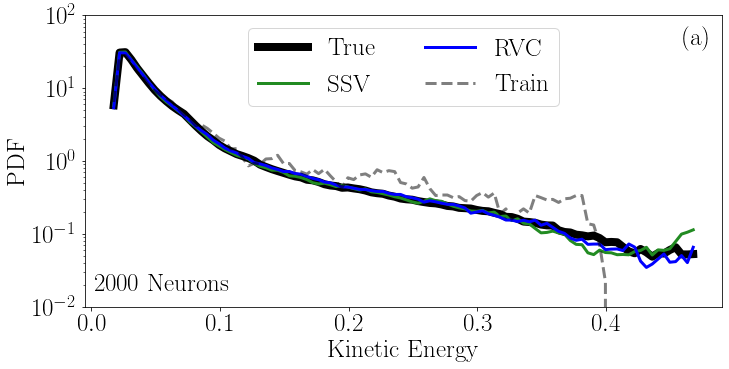

In [105]:
NN_units = [500,1000,1500,2000,2500,3000]
vals     = [SSV,RVC]
SNRs     = [40]
ensemble = 10

un_length  = len(NN_units)
vl_length  = len(vals)
snr_length = len(SNRs)

q1        = .25
q2        = 1 - q1

new       = True

N_range=(0.005,0.48)
N_rang1=(N_range[0]+0.01,N_range[1]-0.01)

fln       = './data/Stats_' + str(N_rang1) + '.h5'
hf        = h5py.File(fln,'r')
errors    = np.array(hf.get('rel-err'))
hists     = np.array(hf.get('bins'))
y         = np.array(hf.get('edges'))
n         = np.array(hf.get('true'))
nn        = np.array(hf.get('train'))
n1        = np.array(hf.get('short'))
hf.close()

bins      = n.shape[0]

markers = ['s', 'o', '^', 'v']
labels  = [ vals[i].__name__ for i in range(len(vals))]
colors  = ['forestgreen', 'blue']


plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["font.size"] = 25

if new:
    n_new = (n[::2]+n[1::2])/2
    y     = y[1::2]
else:
    n_new = n
    y     = y[:-1] + (y[1]-y[0])/2


for i in range(3,4):
    
    plt.subplot(1,1,1)
    
    plt.plot(y, n_new, label='True', linewidth=8, c='black')
    plt.ylabel('PDF')
    
    for k in range(snr_length):
    
        for j in range(vl_length):
            errr = errors[:,i,j,k].copy()
    #         errr[np.where(errr == 0)[0]] = 10
            temp    = np.argsort(errr)
            temp    = temp[ensemble-np.nonzero(errr)[0].shape[0]:]
#             histmin = hists[temp[temp.shape[0]//2] ,i,j,k]
            histmin = hists[np.argmin(errr) ,i,j,k]
            if new:
                hist_new = (histmin[::2]+histmin[1::2])/2
            else:
                hist_new = histmin.copy()
            
            print(labels[j], NN_units[i], (np.abs(hist_new-n_new)/n_new).mean())
            plt.plot(y, hist_new, c=colors[j], label=labels[j],
                    linewidth=3)
                
#             fln = '/data/ar994/Python/Unmeasured_Extreme_Events/Post_Process_data/Noise/' \
#                       'RVC_Statss_' + str(SNRs[k]) + '_' + str(NN_units[i]) + '.h5'
#             hf = h5py.File(fln,'r')
#             Y_stats = np.array(hf.get('Y_stats'))[:]
#             hf.close()
            
#             jj = temp[temp.shape[0]//2] 
#             k3 = 0
#             a  = 0.5*np.linalg.norm(Y_stats[jj],axis=2)**2
#             for i3 in range(a.shape[0]):

#                 minn = a[k3,-10*N_lyap:-1].min()
#                 maxx = a[k3,-10*N_lyap:-1].max()
#                 if (maxx - minn < 0.01 and minn > 0.05) or a[k3].max() > 0.48:
#                     a = np.delete(a,k3,axis=0)
#                     k3 += -1

#                 k3 += 1
                
#             Y_statss    = a.flatten() 
#             mask        = (Y_statss < N_range[1]) & (Y_statss > N_range[0])
#             Y_statss    = Y_statss[mask]
#             density2    = sc.stats.gaussian_kde(Y_statss)
#             dyyy        = density2(y)
#             plt.plot(y, dyyy, label=labels[k], c=colors[k], linewidth=3, alpha=0.8)


    
    if new:
        nn_new = (nn[::2]+nn[1::2])/2
    else:
        nn_new = nn
    plt.plot(y, nn_new, 'k--', label='Train', linewidth=3, alpha=.5)
    print('Train', (np.abs(nn_new-n_new)/n_new).mean())
    
    plt.annotate(str(NN_units[i]) + ' Neurons', xy=(0, 0), xytext=(10, 10), va='bottom', ha='left',
             xycoords='axes fraction', textcoords='offset points')
    plt.ylim(0.01,100)
    plt.yscale('log')
    
#     if i == len(NN_units)-1:
    plt.xlabel('Kinetic Energy')
#     else:
#         plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)

plt.legend(ncol=2, loc='upper center')
plt.annotate('(a)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
                 xycoords='axes fraction', textcoords='offset points')
plt.tight_layout(pad=0.1)
plt.savefig('Noise_Median_PDF' + str(N_rang1) + '.pdf')



[169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199]


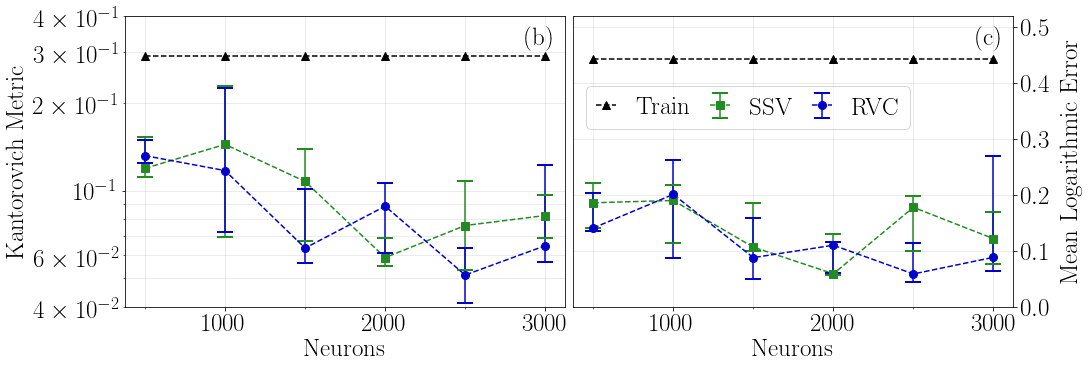

In [20]:
NN_units = [500,1000,1500,2000,2500,3000]
vals     = [SSV,RVC]
SNRs     = [40]
ensemble = 10

un_length  = len(NN_units)
vl_length  = len(vals)
snr_length = len(SNRs)

q1        = .25
q2        = 1 - q1

new       = True

N_range=(0.005,0.48)
N_rang1=(N_range[0]+0.01,N_range[1]-0.01)

fln       = './data/Stats_' + str(N_rang1) + '.h5'
hf        = h5py.File(fln,'r')
errors    = np.array(hf.get('rel-err'))
hists     = np.array(hf.get('bins'))
y         = np.array(hf.get('edges'))
n         = np.array(hf.get('true'))
nn        = np.array(hf.get('train'))
n1        = np.array(hf.get('short'))
hf.close()

bins      = n.shape[0]

markers = ['s', 'o', '^', 'v']
labels  = [ val.__name__ for val in vals]
colors  = ['forestgreen', 'mediumblue']

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25
plt.figure()
ax = plt.subplot(1,2,1)

err_train = sc.stats.wasserstein_distance(n, nn)
err_short = sc.stats.wasserstein_distance(n, n1)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(500))
plt.plot(NN_units, err_train*np.ones(un_length), c='k', linestyle='--', label='Train',
        marker='^', markersize=8)
# plt.axhline(err_train, c='k', linestyle='--')
# plt.axhline(err_short, c='k')

plt.yscale('log')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)


for j in range(vl_length):
    a           = np.zeros(un_length)
    for l in range(snr_length):
        for i in range(un_length):
            errr    = np.zeros(ensemble)
            for k in range(ensemble):
                errr[k]  = sc.stats.wasserstein_distance(n, hists[k,i,j,l])
            errr    = errr[np.nonzero(hists[:,i,j])[0]]
            a[i]    = np.median(errr,axis=0)
            a1      = np.quantile(errr,q1,axis=0)
            a2      = np.quantile(errr,q2,axis=0)
            plt.errorbar(NN_units[i], a[i], 
                 yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                 linestyle='--', c=colors[j], marker=markers[j], markersize=8,
                 capsize=8, capthick=2, label=labels[j], alpha=1)
        plt.plot(NN_units, a, linestyle='--', c=colors[j])
        
plt.annotate('(b)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
                 xycoords='axes fraction', textcoords='offset points')
plt.xlabel('Neurons')
plt.ylim(.04,.4)
plt.ylabel('Kantorovich Metric')

ax = plt.subplot(1,2,2)

err_train = (np.abs(nn-n)/n).mean()
err_short = (np.abs(n1-n)/n).mean()
pwr       = 2
n2        = nn.copy()
print(np.where(n2 == 0)[0])
n2[np.where(n2 == 0)[0]] = \
            n[np.where(n2 == 0)[0]]*10**pwr
plt.plot(NN_units, np.abs(np.log10(n)-np.log10(n2)).mean()*np.ones(un_length), c='k', linestyle='--', label='Train',
        marker='^', markersize=8)
# plt.axhline(np.abs(np.log10(n)-np.log10(n2)).mean(), c='k', linestyle='--', label='Train')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)


for j in range(vl_length):
    a           = np.zeros(un_length)
    for l in range(snr_length):
        for i in range(un_length):
            errr    = np.zeros(ensemble)
            temp    = hists[:,i,j,l].copy()
            for k in range(ensemble):
                hists[k,i,j,l][np.where(hists[k,i,j,l] == 0)[0]] = \
                n[np.where(hists[k,i,j,l] == 0)[0]]*10**pwr
                errr[k] = np.abs(np.log10(n)-np.log10(hists[k,i,j,l])).mean()
#             errr[np.where(errr == 0)[0]] = 10
            errr    = errr[np.nonzero(temp)[0]]
            a[i]    = np.median(errr,axis=0)
            a1      = np.quantile(errr,q1,axis=0)
            a2      = np.quantile(errr,q2,axis=0)
            if i==0:
                plt.errorbar(NN_units[i], a[i], 
                 yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                 linestyle='--', c=colors[j], marker=markers[j], markersize=8,
                 capsize=8, capthick=2, label=labels[j], alpha=1)
            else:
                plt.errorbar(NN_units[i], a[i], 
                 yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                 linestyle='--', c=colors[j], marker=markers[j], markersize=8,
                 capsize=8, capthick=2, alpha=1)
        plt.plot(NN_units, a, linestyle='--', c=colors[j])

plt.annotate('(c)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
                 xycoords='axes fraction', textcoords='offset points')
plt.ylabel('Mean Logarithmic Error', labelpad=10)
ax.yaxis.set_label_position("right")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(500))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.tick_right()
plt.xlabel('Neurons')
plt.ylim(.0,.52)
plt.legend(ncol=3, columnspacing=0.8, handlelength=0.8, bbox_to_anchor=(0.,.8),
           loc='upper left')

plt.tight_layout(pad=0.1)
plt.savefig('Stats_Noise_' + str(np.array(N_rang1)) + '.pdf')

[169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199]
[168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199]


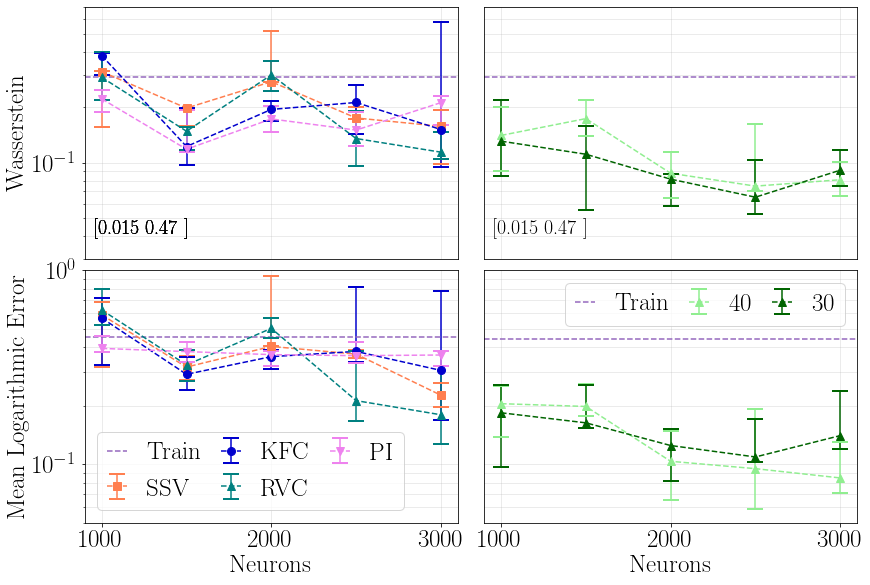

In [120]:
NN_units = [1000,1500,2000,2500,3000]
vals     = [RVC]
SNRs     = [40,30]
ensemble = 10

un_length  = len(NN_units)
vl_length  = len(vals)
snr_length = len(SNRs)

q1        = .25
q2        = 1 - q1

new       = True

N_range=(0.005,0.48)
N_rang1=(N_range[0]+0.01,N_range[1]-0.01)

fln       = './data/Stats_' + str(N_rang1) + '.h5'
hf        = h5py.File(fln,'r')
errors    = np.array(hf.get('rel-err'))
hists     = np.array(hf.get('bins'))
y         = np.array(hf.get('edges'))
n         = np.array(hf.get('true'))
nn        = np.array(hf.get('train'))
n1        = np.array(hf.get('short'))
hf.close()

bins      = n.shape[0]

markers = ['s', 'o', '^', 'v']
labels  = [ str(SNRs[i]) for i in range(len(SNRs))]
colors  = ['lightgreen', 'darkgreen']

plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["font.size"] = 25
plt.figure()
plt.subplot(2,2,2)

err_train = sc.stats.wasserstein_distance(n, nn)
err_short = sc.stats.wasserstein_distance(n, n1)
plt.axhline(err_train, c='C4', linestyle='--')
# plt.axhline(err_short, c='k')

plt.yscale('log')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)


for j in range(vl_length):
    a           = np.zeros(un_length)
    for l in range(snr_length):
        for i in range(un_length):
            errr    = np.zeros(ensemble)
            for k in range(ensemble):
                errr[k]  = sc.stats.wasserstein_distance(n, hists[k,i,j,l])
            errr    = errr[np.nonzero(hists[:,i,j])[0]]
            a[i]    = np.median(errr,axis=0)
            a1      = np.quantile(errr,q1,axis=0)
            a2      = np.quantile(errr,q2,axis=0)
            plt.errorbar(NN_units[i], a[i], 
                 yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                 linestyle='--', c=colors[l], marker=markers[2], markersize=8,
                 capsize=8, capthick=2, label=labels[l], alpha=1)
        plt.plot(NN_units, a, linestyle='--', c=colors[l])
    plt.annotate(str(np.array(N_rang1)), xy=(0, 0), xytext=(10, 20), va='bottom', ha='left',
             xycoords='axes fraction', textcoords='offset points',fontsize=20)
plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)
plt.ylim(0.03,0.7)

plt.subplot(2,2,4)

err_train = (np.abs(nn-n)/n).mean()
err_short = (np.abs(n1-n)/n).mean()
pwr       = 2
n2        = nn.copy()
print(np.where(n2 == 0)[0])
n2[np.where(n2 == 0)[0]] = \
            n[np.where(n2 == 0)[0]]*10**pwr
plt.axhline(np.abs(np.log10(n)-np.log10(n2)).mean(), c='C4', linestyle='--', label='Train')
# plt.axhline(err_short, c='k')
# plt.yscale('log')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)


for j in range(vl_length):
    a           = np.zeros(un_length)
    for l in range(snr_length):
        for i in range(un_length):
            errr    = np.zeros(ensemble)
            temp    = hists[:,i,j,l].copy()
            for k in range(ensemble):
                hists[k,i,j,l][np.where(hists[k,i,j,l] == 0)[0]] = \
                n[np.where(hists[k,i,j,l] == 0)[0]]*10**pwr
                errr[k] = np.abs(np.log10(n)-np.log10(hists[k,i,j,l])).mean()
#             errr[np.where(errr == 0)[0]] = 10
            errr    = errr[np.nonzero(temp)[0]]
            a[i]    = np.median(errr,axis=0)
            a1      = np.quantile(errr,q1,axis=0)
            a2      = np.quantile(errr,q2,axis=0)
            if i==0:
                plt.errorbar(NN_units[i], a[i], 
                 yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                 linestyle='--', c=colors[l], marker=markers[2], markersize=8,
                 capsize=8, capthick=2, label=labels[l], alpha=1)
            else:
                plt.errorbar(NN_units[i], a[i], 
                 yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                 linestyle='--', c=colors[l], marker=markers[2], markersize=8,
                 capsize=8, capthick=2, alpha=1)
        plt.plot(NN_units, a, linestyle='--', c=colors[l])
#     plt.annotate(str(np.array(N_rang1)), xy=(0, 0), xytext=(10, 20), va='bottom', ha='left',
#              xycoords='axes fraction', textcoords='offset points',fontsize=20)

plt.xlabel('Neurons')
# plt.ylabel('Mean Logarithmic Error')
plt.yscale('log')
plt.ylim(0.05,1)
plt.legend(ncol=3, columnspacing=0.8, handlelength=0.8)


NN_units = [1000,1500,2000,2500,3000]
vals     = [SSV, KFC, RVC, RVC_PI]
ensemble = 10

un_length = len(NN_units)
vl_length = len(vals)

q1        = .25
q2        = 1 - q1

new       = True

# N_range=(0.005,0.48)
# N_rang1=(N_range[0]+0.01,N_range[1]-0.01)

fln       = '../MFE_Sri/data/Stats_' + str(N_rang1) + '.h5'
hf        = h5py.File(fln,'r')
errors    = np.array(hf.get('rel-err'))
hists     = np.array(hf.get('bins'))
y         = np.array(hf.get('edges'))
n         = np.array(hf.get('true'))
nn        = np.array(hf.get('train'))
n1        = np.array(hf.get('short'))
hf.close()

markers = ['s', 'o', '^', 'v']
labels  = ['SSV', 'KFC', 'RVC', 'PI']
colors  = ['coral', 'mediumblue', 'teal', 'violet']


plt.subplot(2,2,1)

err_train = sc.stats.wasserstein_distance(n, nn)
err_short = sc.stats.wasserstein_distance(n, n1)
plt.axhline(err_train, c='C4', linestyle='--')
# plt.axhline(err_short, c='k')

plt.yscale('log')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)


for j in range(vl_length):
    a           = np.zeros(un_length)
    for i in range(un_length):
        errr    = np.zeros(ensemble)
        for k in range(ensemble):
            errr[k]  = sc.stats.wasserstein_distance(n, hists[k,i,j])
        errr    = errr[np.nonzero(hists[:,i,j])[0]]
        a[i]    = np.median(errr,axis=0)
        a1      = np.quantile(errr,q1,axis=0)
        a2      = np.quantile(errr,q2,axis=0)
        plt.errorbar(NN_units[i], a[i], 
             yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
             linestyle='--', c=colors[j], marker=markers[j], markersize=8,
             capsize=8, capthick=2, label=labels[j], alpha=1)
    plt.plot(NN_units, a, linestyle='--', c=colors[j])
    plt.annotate(str(np.array(N_rang1)), xy=(0, 0), xytext=(10, 20), va='bottom', ha='left',
             xycoords='axes fraction', textcoords='offset points',fontsize=20)

plt.ylim(0.03,0.7)
plt.ylabel('Wasserstein')
plt.subplot(2,2,3)

err_train = (np.abs(nn-n)/n).mean()
err_short = (np.abs(n1-n)/n).mean()
pwr       = 2
n2        = nn.copy()
print(np.where(n2 == 0)[0])
n2[np.where(n2 == 0)[0]] = \
            n[np.where(n2 == 0)[0]]*10**pwr
plt.axhline(np.abs(np.log10(n)-np.log10(n2)).mean(), c='C4', linestyle='--', label='Train')
# plt.axhline(err_short, c='k')

plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)


for j in range(vl_length):
    a           = np.zeros(un_length)
    for i in range(un_length):
        errr    = np.zeros(ensemble)
        temp    = hists[:,i,j].copy()
        for k in range(ensemble):
            hists[k,i,j][np.where(hists[k,i,j] == 0)[0]] = \
            n[np.where(hists[k,i,j] == 0)[0]]*10**pwr
            errr[k] = np.abs(np.log10(n)-np.log10(hists[k,i,j])).mean()
        errr    = errr[np.nonzero(temp)[0]]
        a[i]    = np.median(errr,axis=0)
        a1      = np.quantile(errr,q1,axis=0)
        a2      = np.quantile(errr,q2,axis=0)
        if i==0:
            plt.errorbar(NN_units[i], a[i], 
             yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
             linestyle='--', c=colors[j], marker=markers[j], markersize=8,
             capsize=8, capthick=2, label=labels[j], alpha=1)
        else:
            plt.errorbar(NN_units[i], a[i], 
             yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
             linestyle='--', c=colors[j], marker=markers[j], markersize=8,
             capsize=8, capthick=2, alpha=1)
    plt.plot(NN_units, a, linestyle='--', c=colors[j])
#     plt.annotate(str(np.array(N_rang1)), xy=(0, 0), xytext=(10, 20), va='bottom', ha='left',
#              xycoords='axes fraction', textcoords='offset points',fontsize=20)

plt.xlabel('Neurons')
plt.ylabel('Mean Logarithmic Error')
plt.yscale('log')
plt.ylim(0.05,1)
plt.legend(ncol=3, columnspacing=0.8, handlelength=0.8)



plt.tight_layout(pad=0.1)
plt.savefig('Log_Error_Noise_' + str(np.array(N_rang1)) + '.pdf')

In [13]:
# midpoints     = 0.5 * (yy[1:] + yy[:-1])
# ev            = np.average(midpoints, weights = nn)
# Stat_train    = np.zeros(5)
# Stat_train[0] = ev
# for k in range(2, 6):
#     Stat_train[k-1] = np.average((midpoints - ev)**k, weights = nn)

# print('Train', sc.stats.wasserstein_distance(n, nn), 
#      sc.stats.entropy(nn, qk=n, base=None, axis=0))
    
# midpoints = 0.5 * (y[1:] + y[:-1])
# ev = np.average(midpoints, weights = n)
# Stat_true    = np.zeros(5)
# Stat_true[0] = ev
# for k in range(2, 6):
#     Stat_true[k-1] = np.average((midpoints - ev)**k, weights = n)

# plt.figure()
# for j in vals:

#     fln = './data/'+ j.__name__ + '_Statss_' + str(N_units) + '.h5'
#     hf = h5py.File(fln,'r')
#     Y_stats = np.array(hf.get('Y_stats'))[:]
#     hf.close()
    
#     b  = N_range[0]
#     kk = 0
    
#     for jj in range(Y_stats.shape[0]):
#         k=0
# #         a  = Y_stats[jj]
#         a  = 0.5*np.linalg.norm(Y_stats[jj],axis=2)**2
#         for i in range(a.shape[0]):
        
#             minn = a[k,-5*N_lyap:-1].min()
#             maxx = a[k,-5*N_lyap:-1].max()
#             if (maxx - minn < 0.01 and minn > 0.05) or a[k].max() > 0.48:
#                 a = np.delete(a,k,axis=0)
#                 k  += -1
#                 k1 += 1
            
#             k += 1
        
#         kk += k
        
#         b = np.append(b,a.flatten())
        
#     Y_stats   = b 
#     mask      = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
#     Y_stats   = Y_stats[mask]
# #     nnn, yyy, _ = plt.hist(Y_stats, bins=200, range=N_rang1, # bins=np.linspace(minn,maxx, 100) 
# #                        histtype=u'step', density=True, log=True, alpha=0.001, color='k')
#     nnn, yyy = np.histogram(Y_stats, bins=200, range=N_rang1,density=True)
    
#     midpoints = 0.5 * (yyy[1:] + yyy[:-1])
#     ev = np.average(midpoints, weights = nnn)
#     Stat_esn    = np.zeros(5)
#     Stat_esn[0] = ev
#     for k in range(2, 6):
#         Stat_esn[k-1] = np.average((midpoints - ev)**k, weights = nnn)
    
#     plt.plot(np.abs((Stat_esn - Stat_true)) / Stat_true, marker='o', label='$'+j.__name__+'$')
#     print(j.__name__, sc.stats.wasserstein_distance(n, nnn),
#          sc.stats.entropy(nnn, qk=n, base=None, axis=0))


# print('')


# plt.plot(np.abs((Stat_train - Stat_true)) / Stat_true, marker='o', label='Train')
# plt.yscale('log')
# plt.ylabel('Relative Error')
# plt.xlabel('Moments')
# plt.legend(ncol=2)
# plt.grid(True, axis="y", which='both', ls="-", alpha=0.3)
# plt.xticks(np.arange(5), ['$\mu$', '2', '3', '4', '5'])
# plt.tight_layout()
# plt.savefig('Moments' + str(N_units) + '.pdf')

# plt.show()

NameError: name 'yy' is not defined

## Velocity Profiles

In [121]:
fln = './data/V_mean.h5'
hf = h5py.File(fln,'r')
um = np.array(hf.get('u_x'))
hf.close()

X       = np.linspace(0,4*math.pi,um.shape[0]) 
Y       = np.linspace(0,1,um.shape[1])
Z       = np.linspace(0,2*math.pi,um.shape[2])
XX      = np.meshgrid(X, Y, Z, indexing='ij')

x, y, z = XX
M       = MFE_modes(XX)


UU_tv  = U_tv.reshape(N1_val*(N_train+N_val-1), Ndim)
print(M[:,0].shape, UU_tv.shape, np.tensordot(M[:,0], UU_tv, axes=[[0], [1]]).shape)

uv    = False
mom   = True
power = 4

if uv:
    vx_mean  = (np.tensordot(M[:,0], UU_tv, axes=[[0], [1]])*
               np.tensordot(M[:,1], UU_tv, axes=[[0], [1]])).mean(axis=(0,2,3))
else:
    AA       = np.tensordot(M[:,0], UU_tv, axes=[[0], [1]])
    if mom: AA += - np.stack([um]*UU_tv.shape[0],axis=3)
    BB       = AA.copy()
    for p in range(power-1):
        BB *= AA
    vx_mean = (BB).mean(axis=(0,2,3))


vxx_mean = 0
v_mean   = 0
b        = U[:N1*500].copy()
den      = 10
idd      = b.shape[0]//den
print(b.shape)
for ii in range(den):
    if uv:
        vxx_mean += (np.tensordot(M[:,0],b[ii*idd:(ii+1)*(idd)],axes=[[0], [1]])*
                     np.tensordot(M[:,1],b[ii*idd:(ii+1)*(idd)],axes=[[0], [1]])
                     ).mean(axis=(0,2,3))/den
    else:
        AA        = np.tensordot(M[:,0],b[ii*idd:(ii+1)*(idd)],axes=[[0], [1]])
        if mom: AA += - np.stack([um]*idd,axis=3)
        BB        = AA.copy()
        for p in range(power-1):
            BB   *= AA #need to be this way to use multicore, no np.power
        vxx_mean += (BB).mean(axis=(0,2,3))/den
    
#     v_mean += np.tensordot(M[:,0],b[ii*idd:(ii+1)*(idd)],axes=[[0], [1]]).mean(axis=3)/den  

# fln = './data/V_mean.h5'
# hf = h5py.File(fln,'w')
# hf.create_dataset('u_x'   ,data=v_mean)
# hf.close()

(9, 12, 20, 12) (38990, 9) (12, 20, 12, 38990)
(2000000, 9)


In [ ]:
val       = [SSV, RVC]
NN_units  = [500,1000,1500,2000,2500,3000]

ensemble  = 10

vesn_mean = np.zeros((ensemble, len(NN_units), len(val), Y.shape[0])) 
Nbs       = np.zeros((ensemble, len(NN_units), len(val))) 

# needs to be averages only on axis=3 (time)
# fln    = './data/Vesn_mom' + str(mom) + '_' + str(power)+'.h5'
# hf     = h5py.File(fln,'r')
# um_esn = np.array(hf.get('vesn'))
# hf.close()

k1 = 0
for N_units in NN_units:
    k2 = 0
    for j in val:

        fln = '/data/ar994/Python/Unmeasured_Extreme_Events/Post_Process_data/Noise/' \
              + j.__name__ + '_Statss_40_' + str(N_units) + '.h5'
        hf = h5py.File(fln,'r')
        Yy = np.array(hf.get('Y_stats'))[:]
        hf.close()
        print(j.__name__, N_units)

        vens       = np.zeros((Yy.shape[0], Y.shape[0]))
        Nb         = np.zeros(Yy.shape[0])
        for ii in range(Yy.shape[0]):

            k  = 0
            a  = 0.5*np.linalg.norm(Yy[ii],axis=2)**2
            b  = Yy[ii].copy()
            for i in range(a.shape[0]):

                minn = a[i,-5*N_lyap:-1].min()
                maxx = a[i,-5*N_lyap:-1].max()
                if (maxx - minn < 0.01 and minn > 0.05) or a[i].max() > 0.48:
                    b = np.delete(b,k,axis=0)
                    k  += -1
                k += 1

            Nb[ii]        = b.shape[0]*b.shape[1]
            Nbs[ii,k1,k2] = Nb[ii]*1
            b             = b.reshape(int(Nb[ii]), Ndim)
            print(b.shape)

            if b.shape[0] > 0:
                den        = 4
                idd        = b.shape[0]//den
                vens [ii]  = 0
                for iii in range(den):
                    if uv:
                        vens[ii] += (np.tensordot(M[:,0],b[iii*idd:(iii+1)*(idd)],axes=[[0], [1]])*
                                     np.tensordot(M[:,1],b[iii*idd:(iii+1)*(idd)],axes=[[0], [1]])
                                     ).mean(axis=(0,2,3))/den
                    else:
                        AA        = np.tensordot(M[:,0],b[iii*idd:(iii+1)*(idd)],axes=[[0], [1]])
                        if mom: AA += - np.stack([um]*idd,axis=3)
                        BB        = 1
                        for p in range(power):
                            BB   *= AA #need to be this way to use multicore, no np.power
                        vens[ii] += BB.mean(axis=(0,2,3))/den
                        
            vesn_mean[ii,k1,k2]   = vens[ii].copy() 
            
#         vesn_mean[k1,k2] = np.average(vens, axis=0, weights=Nb)
        k2              += 1
    k1              += 1
    
fln = './data/Vesn_mom' + str(mom) + '_' + str(power)+'.h5'
hf = h5py.File(fln,'w')
hf.create_dataset('vesn'   ,data=vesn_mean)
hf.create_dataset('weights',data=Nbs)
hf.create_dataset('vtrue'  ,data=vxx_mean)
hf.create_dataset('vtrain' ,data=vx_mean)
hf.close()

SSV 500
(1548000, 9)
(1072000, 9)
(1596000, 9)
(1404000, 9)
(1540000, 9)
(1672000, 9)
(1208000, 9)
(1824000, 9)
(1292000, 9)
(1664000, 9)
RVC 500
(1716000, 9)
(1496000, 9)
(1848000, 9)
(1208000, 9)
(1532000, 9)
(1580000, 9)
(1612000, 9)
(1600000, 9)
(1852000, 9)
(1472000, 9)
SSV 1000
(1200000, 9)
(1932000, 9)
(1608000, 9)
(1832000, 9)
(1664000, 9)
(1940000, 9)
(1420000, 9)
(1900000, 9)
(1392000, 9)
(1868000, 9)
RVC 1000
(1820000, 9)
(1896000, 9)
(1516000, 9)
(1476000, 9)


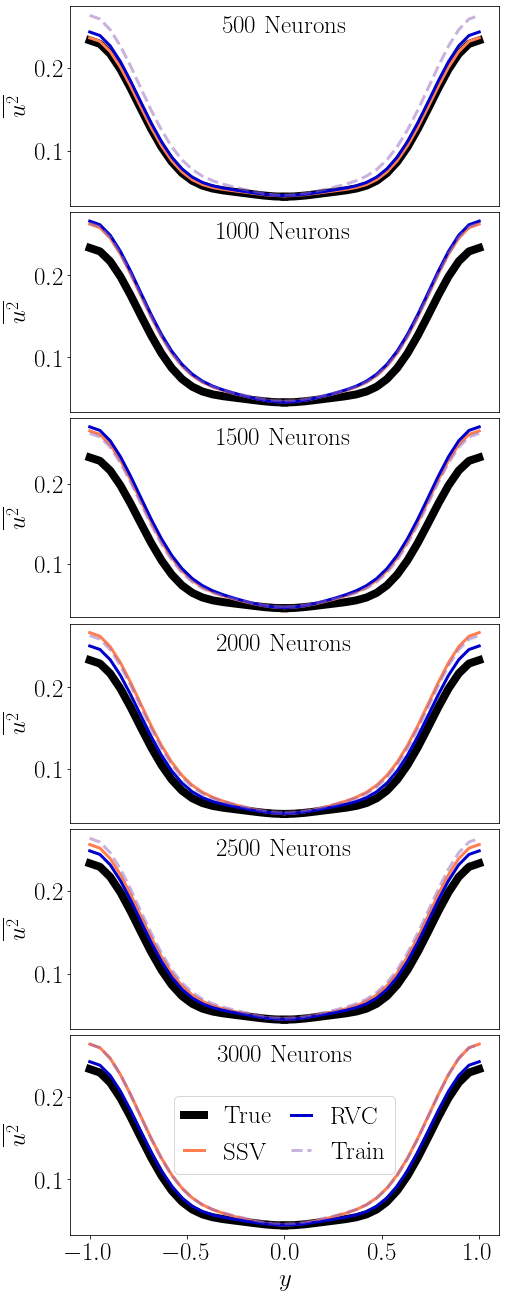

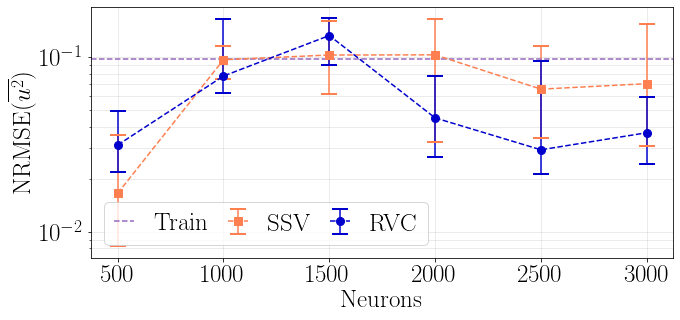

In [149]:
fln = './data/V_mean.h5'
hf = h5py.File(fln,'r')
um = np.array(hf.get('u_x'))
hf.close()

X       = np.linspace(0,4*math.pi,um.shape[0]) 
Y       = np.linspace(0,1,um.shape[1])
Y1      = np.linspace(-1,0,um.shape[1])   
Z       = np.linspace(0,2*math.pi,um.shape[2])
XX      = np.meshgrid(X, Y, Z, indexing='ij')

x, y, z   = XX
M         = MFE_modes(XX)
val       = [SSV, RVC]
NN_units  = [500,1000,1500,2000,2500,3000]
ensemble  = 10

plt.rcParams["figure.figsize"] = (7,3*len(NN_units))
plt.rcParams["font.size"] = 25


q1        = .25
q2        = 1 - q1

mom   = False
power = 4

fln = './data/Vesn_mom' + str(mom) + '_' + str(power)+'.h5'
hf = h5py.File(fln,'r')
vesn_mean = np.array(hf.get('vesn'))
Nbs       = np.array(hf.get('weights'))
vxx_mean  = np.array(hf.get('vtrue'))
vx_mean   = np.array(hf.get('vtrain'))
hf.close()

norm      = vxx_mean.max() - vxx_mean.min()

un_length = len(NN_units)
vl_length = len(val)

errors    = np.zeros((ensemble,len(NN_units),len(val)))

markers = ['s', 'o', '^', 'v']
labels  = [vals.__name__ for vals in val]
colors  = ['coral', 'mediumblue', 'teal', 'violet']

plt.subplots(un_length,1)

for i in np.arange(un_length): #plotting all the units
    plt.subplot(un_length,1,i+1)
    
    plt.plot(Y1, np.flip(vxx_mean), c='k', linewidth=8)
    plt.plot(Y, vxx_mean, label='True', c='k', linewidth=8)
    
        
    for j in range(vl_length): #plotting all the val functions
        vv_mean = np.average(vesn_mean[:,i,j], axis=0, weights=Nbs[:,i,j])
        plt.plot(Y, vv_mean, label = labels[j], c=colors[j], linewidth=3)
        plt.plot(Y1, np.flip(vv_mean), c=colors[j], linewidth=3)
        errors[:,i,j] = np.sqrt(np.square(vesn_mean[:,i,j]-vxx_mean).mean(axis=1))/norm
#         print(NN_units[i],val[j].__name__, errors[:,i,j],
#              np.sqrt(np.square(vv_mean-vxx_mean).mean())/norm)
    
    plt.plot(Y, vx_mean, '--C4', label ='Train', linewidth=3, alpha=0.5)
    plt.plot(Y1, np.flip(vx_mean), '--C4', linewidth=3, alpha=0.5)
    err_train = np.sqrt(np.square(vx_mean-vxx_mean).mean())/norm
#     print(NN_units[i], 'Train', err_train)
#     print('')

        
    plt.ylabel('$\overline{u^{'+str(power)+'}}$')
    if i==un_length-1: 
        plt.xlabel('$y$')
        plt.legend(ncol=2,columnspacing=0.8,handlelength=0.8, loc='center')
    else:
        plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)
        
    plt.annotate(str(NN_units[i]) + ' Neurons', xy=(.5, 1), xytext=(0, -10),
                 va='top', ha='center',
             xycoords='axes fraction', textcoords='offset points')
plt.tight_layout(pad=0.25)

plt.savefig('Plot' + str(mom) + '_' + str(power)+'.pdf')

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["font.size"] = 25
plt.figure()
plt.yscale('log')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
plt.axhline(err_train, c='C4', linestyle='--', label='Train')

markers = ['s', 'o', '^', 'v']
colors  = ['coral', 'mediumblue', 'teal', 'violet']

for j in range(vl_length):
    a           = np.zeros(un_length)
    for i in range(un_length):
        errr    = errors[:,i,j][np.nonzero(Nbs[:,i,j])]
        a[i]    = np.median(errr,axis=0)
        a1      = np.quantile(errr,q1,axis=0)
        a2      = np.quantile(errr,q2,axis=0)
#         print(labels[j], NN_units[i], len(errr))
        if i==0:
            plt.errorbar(NN_units[i], a[i], 
                 yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                 linestyle='--', c=colors[j], marker=markers[j], markersize=8,
                 capsize=8, capthick=2, label=labels[j], alpha=1)
        else:
            plt.errorbar(NN_units[i], a[i], 
                 yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                 linestyle='--', c=colors[j], marker=markers[j], markersize=8,
                 capsize=8, capthick=2, alpha=1)
    plt.plot(NN_units, a, linestyle='--', c=colors[j])
plt.legend(ncol=3,columnspacing=0.8,handlelength=0.8)
plt.xlabel('Neurons')
plt.ylabel('NRMSE($\overline{u^{'+str(power)+'}}$)')
plt.tight_layout()
plt.savefig('Errors' + str(mom) + '_' + str(power)+'.pdf')

plt.show()

## Flowfiled Statistics

(9, 50, 2, 50) (38990, 9) (50, 2, 50, 38990)
(48, 48)


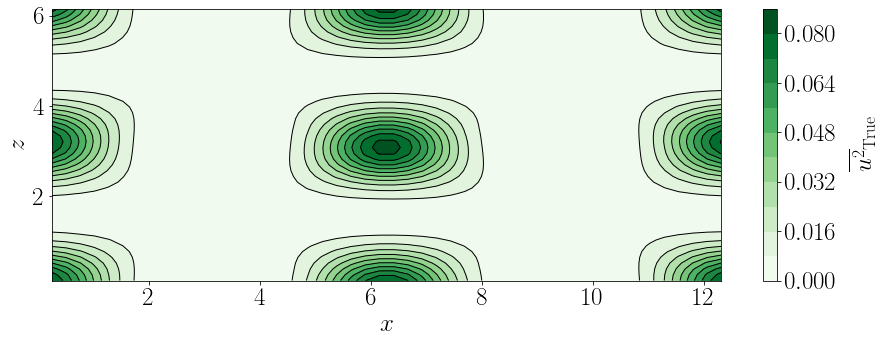

(2000000, 9)


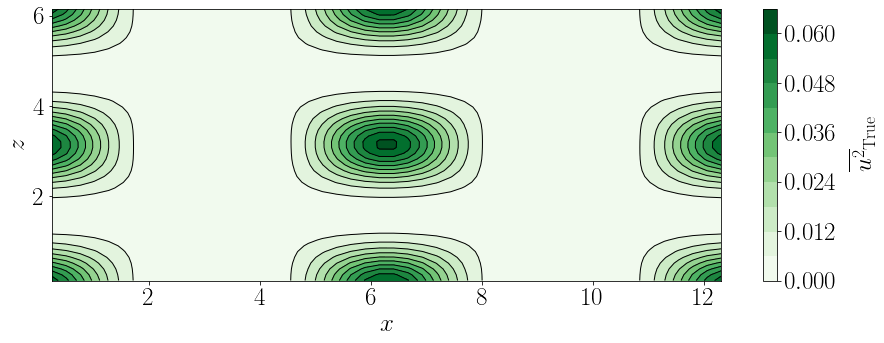

In [46]:
# fln = './data/V_mean.h5'
# hf = h5py.File(fln,'r')
# um = np.array(hf.get('u_x'))
# hf.close()

um      = [50,2,50]

X       = np.linspace(0,4*math.pi,um[0]) 
Y       = np.linspace(0,1,um[1])
Z       = np.linspace(0,2*math.pi,um[2])
XX      = np.meshgrid(X, Y, Z, indexing='ij')

x, y, z = XX
M       = MFE_modes(XX)


UU_tv  = U_tv.reshape(N1_val*(N_train+N_val-1), Ndim)
print(M[:,0].shape, UU_tv.shape, np.tensordot(M[:,0], UU_tv, axes=[[0], [1]]).shape)

uv    = True #if true we are computing the vorticity
mom   = False
power = 6

if uv:
    ux      = np.tensordot(M[:,0], UU_tv, axes=[[0], [1]])[:,0]
    uz      = np.tensordot(M[:,2], UU_tv, axes=[[0], [1]])[:,0]
    
    ux      = (ux[1:-1,2:] - ux[1:-1,:-2])/(2*(Z[1]-Z[0])) #dux_dz
    uz      = (uz[2:,1:-1] - uz[:-2,1:-1])/(2*(X[1]-X[0])) #duz_dx
    
    vx_mean = ((uz - ux)**power).mean(axis=(2))
    
else:
    AA       = np.tensordot(M[:,0], UU_tv, axes=[[0], [1]])
    if mom: AA += - np.stack([um]*UU_tv.shape[0],axis=3)
    BB       = AA.copy()
    for p in range(power-1):
        BB *= AA
    vx_mean = (BB[:,0]).mean(axis=(2))

print(vx_mean.shape)

ax = plt.subplot(111)
if uv:
    CS     = plt.contourf(XX[0][1:-1,0,1:-1], XX[2][1:-1,0,1:-1], vx_mean,levels=10,cmap='Greens')
    cbar = plt.colorbar()
    cbar.set_label('$\overline{u^2}_{\mathrm{True}}$',labelpad=15)
    CS    = plt.contour(XX[0][1:-1,0,1:-1], XX[2][1:-1,0,1:-1], vx_mean,levels=10,colors='black',
                                  linewidths=1, linestyles='solid')
else:
    CS     = plt.contourf(XX[0][:,0,:], XX[2][:,0,:], vx_mean,levels=10,cmap='Greens')
    cbar = plt.colorbar()
    cbar.set_label('$\overline{u^2}_{\mathrm{True}}$',labelpad=15)
    CS    = plt.contour(XX[0][:,0,:], XX[2][:,0,:], vx_mean,levels=10,colors='black',
                                  linewidths=1, linestyles='solid')
plt.xlabel('$x$')
plt.ylabel('$z$')
plt.show()

vxx_mean = 0
v_mean   = 0
b        = U[:N1*500].copy()
den      = 10
idd      = b.shape[0]//den
print(b.shape)
for ii in range(den):
    if uv:
        
        ux      = np.tensordot(M[:,0], b[ii*idd:(ii+1)*(idd)], axes=[[0], [1]])[:,0]
        uz      = np.tensordot(M[:,2], b[ii*idd:(ii+1)*(idd)], axes=[[0], [1]])[:,0]
    
        ux      = (ux[1:-1,2:] - ux[1:-1,:-2])/(2*(Z[1]-Z[0])) #dux_dz
        uz      = (uz[2:,1:-1] - uz[:-2,1:-1])/(2*(X[1]-X[0])) #duz_dx
        
        BB      = 1
        for p in range(power):
            BB   *= (uz - ux)
        vxx_mean += BB.mean(axis=(2))/den
    
    else:
        AA        = np.tensordot(M[:,0],b[ii*idd:(ii+1)*(idd)],axes=[[0], [1]])
        if mom: AA += - np.stack([um]*idd,axis=3)
        BB        = AA.copy()
        for p in range(power-1):
            BB   *= AA #need to be this way to use multicore, no np.power
        vxx_mean += (BB[:,0]).mean(axis=(2))/den
        
ax = plt.subplot(111)
if uv:
    CS     = plt.contourf(XX[0][1:-1,0,1:-1], XX[2][1:-1,0,1:-1], vxx_mean,levels=10,cmap='Greens')
    cbar = plt.colorbar()
    cbar.set_label('$\overline{u^2}_{\mathrm{True}}$',labelpad=15)
    CS    = plt.contour(XX[0][1:-1,0,1:-1], XX[2][1:-1,0,1:-1], vxx_mean,levels=10,colors='black',
                                  linewidths=1, linestyles='solid')
else:
    CS     = plt.contourf(XX[0][:,0,:], XX[2][:,0,:], vxx_mean,levels=10,cmap='Greens')
    cbar = plt.colorbar()
    cbar.set_label('$\overline{u^2}_{\mathrm{True}}$',labelpad=15)
    CS    = plt.contour(XX[0][:,0,:], XX[2][:,0,:], vxx_mean,levels=10,colors='black',
                                  linewidths=1, linestyles='solid')
plt.xlabel('$x$')
plt.ylabel('$z$')
plt.show()
    
#     v_mean += np.tensordot(M[:,0],b[ii*idd:(ii+1)*(idd)],axes=[[0], [1]]).mean(axis=3)/den  

# fln = './data/V_mean.h5'
# hf = h5py.File(fln,'w')
# hf.create_dataset('u_x'   ,data=v_mean)
# hf.close()

In [47]:
val       = [RVC]
NN_units  = [2000]

ensemble  = 10

if uv:
    vesn_mean = np.zeros((ensemble, len(NN_units), len(val), um[0]-2,um[2]-2)) 
else:
    vesn_mean = np.zeros((ensemble, len(NN_units), len(val), um[0],um[2])) 

Nbs       = np.zeros((ensemble, len(NN_units), len(val))) 

# needs to be averages only on axis=3 (time)
# fln    = './data/Vesn_mom' + str(mom) + '_' + str(power)+'.h5'
# hf     = h5py.File(fln,'r')
# um_esn = np.array(hf.get('vesn'))
# hf.close()

k1 = 0
for N_units in NN_units:
    k2 = 0
    for j in val:

        fln = '/data/ar994/Python/Unmeasured_Extreme_Events/Post_Process_data/Noise/' \
              + j.__name__ + '_Statss_40_' + str(N_units) + '.h5'
        hf = h5py.File(fln,'r')
        Yy = np.array(hf.get('Y_stats'))[:]
        hf.close()
        print(j.__name__, N_units)
        
        if uv:
            vens       = np.zeros((Yy.shape[0], um[0]-2,um[2]-2))
        else:
            vens       = np.zeros((Yy.shape[0], um[0],um[2]))
                
        Nb         = np.zeros(Yy.shape[0])
        for ii in range(Yy.shape[0]):

            k  = 0
            a  = 0.5*np.linalg.norm(Yy[ii],axis=2)**2
            b  = Yy[ii].copy()
            for i in range(a.shape[0]):

                minn = a[i,-5*N_lyap:-1].min()
                maxx = a[i,-5*N_lyap:-1].max()
                if (maxx - minn < 0.01 and minn > 0.05) or a[i].max() > 0.48:
                    b = np.delete(b,k,axis=0)
                    k  += -1
                k += 1

            Nb[ii]        = b.shape[0]*b.shape[1]
            Nbs[ii,k1,k2] = Nb[ii]*1
            b             = b.reshape(int(Nb[ii]), Ndim)
            print(b.shape)

            if b.shape[0] > 0:
                den        = 4
                idd        = b.shape[0]//den
                vens [ii]  = 0
                for iii in range(den):
                    if uv:
                        ux      = np.tensordot(M[:,0], b[iii*idd:(iii+1)*(idd)],
                                               axes=[[0], [1]])[:,0]
                        uz      = np.tensordot(M[:,2], b[iii*idd:(iii+1)*(idd)],
                                               axes=[[0], [1]])[:,0]

                        ux      = (ux[1:-1,2:] - ux[1:-1,:-2])/(2*(Z[1]-Z[0])) #dux_dz
                        uz      = (uz[2:,1:-1] - uz[:-2,1:-1])/(2*(X[1]-X[0])) #duz_dx
                        
                        BB        = 1
                        for p in range(power):
                            BB   *= (uz - ux)
                        vens[ii] += BB.mean(axis=(2))/den
                        
                    else:
                        AA        = np.tensordot(M[:,0],b[iii*idd:(iii+1)*(idd)],axes=[[0], [1]])
                        if mom: AA += - np.stack([um]*idd,axis=3)
                        BB        = 1
                        for p in range(power):
                            BB   *= AA #need to be this way to use multicore, no np.power
                        vens[ii] += (BB[:,0]).mean(axis=(2))/den
                        
            vesn_mean[ii,k1,k2]   = vens[ii].copy() 
            
#         vesn_mean[k1,k2] = np.average(vens, axis=0, weights=Nb)
        k2              += 1
    k1              += 1

    
if uv:
    fln = './data/Vesn_flow' + str(mom) + '_' + str(power)+'_vort.h5' 
else:   
    fln = './data/Vesn_flow' + str(mom) + '_' + str(power)+'.h5'
hf = h5py.File(fln,'w')
hf.create_dataset('vesn'   ,data=vesn_mean)
hf.create_dataset('weights',data=Nbs)
hf.create_dataset('vtrue'  ,data=vxx_mean)
hf.create_dataset('vtrain' ,data=vx_mean)
hf.close()

RVC 2000
(1380000, 9)
(1360000, 9)
(1552000, 9)
(1528000, 9)
(1504000, 9)
(1632000, 9)
(1408000, 9)
(1264000, 9)
(1244000, 9)
(1588000, 9)
